In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [2]:
def white_stripe_normalization(image, bandwidth=20.0, tau=0.15):
    """Robust White Stripe normalization with background preservation"""
    img = image.astype(np.float32)
    
    # 1. Separate background and brain region
    otsu_thresh, _ = cv2.threshold(image.astype(np.uint8), 0, 255, 
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    brain_mask = image > (otsu_thresh * 0.8)
    
    if np.count_nonzero(brain_mask) < 100:  # Fallback for empty masks
        brain_mask = image > image.mean()
    
    brain_pixels = img[brain_mask]

    # 2. Dynamic histogram range for brain region only
    min_val, peak_val, max_val = np.percentile(brain_pixels, [2, 50, 98])
    hist_bins = np.linspace(min_val, max_val, 500)
    hist, bins = np.histogram(brain_pixels, bins=hist_bins, density=True)
    
    # 3. Conservative peak detection
    hist_smoothed = gaussian_filter1d(hist, bandwidth)
    peak_window = bins[(bins >= peak_val) & (bins <= max_val)]
    if len(peak_window) > 0:
        peak_intensity = peak_window[np.argmax(hist_smoothed[-len(peak_window):])]
    else:
        peak_intensity = np.median(brain_pixels)

    # 4. White stripe selection within brain region
    ws_values = brain_pixels[
        (brain_pixels >= peak_intensity * (1 - tau)) & 
        (brain_pixels <= peak_intensity * (1 + tau))
    ]
    
    if len(ws_values) < 50:
        ws_mean, ws_std = np.median(brain_pixels), np.std(brain_pixels)
    else:
        ws_mean, ws_std = np.mean(ws_values), np.std(ws_values)
    
    # 5. Safeguarded normalization
    if ws_std < 1e-6:
        return img / img.max()  # Fallback to simple scaling
    
    normalized = (img - ws_mean) / ws_std
    
    # 6. Soft scaling based on brain region percentiles
    p_low, p_high = np.percentile(normalized[brain_mask], [5, 95])
    scaled = (normalized - p_low) / (p_high - p_low + 1e-8)
    
    # 7. Preserve original background darkness
    result = np.zeros_like(img)
    result[brain_mask] = np.clip(scaled[brain_mask], 0, 1)  # Only scale brain region
    return result

In [3]:
def process_dataset(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)
        os.makedirs(output_class_path, exist_ok=True)
        
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}"):
            input_path = os.path.join(class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            try:
                # Read with explicit grayscale conversion
                image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    raise ValueError("Invalid image file")
                
                # Normalize and preserve background
                normalized = white_stripe_normalization(image)
                
                # Convert to uint8 while keeping background dark
                output = np.where(normalized > 0, 
                                (normalized * 255).astype(np.uint8), 
                                0)
                
                cv2.imwrite(output_path, output)
                
            except Exception as e:
                print(f"Error processing {input_path}: {str(e)}")

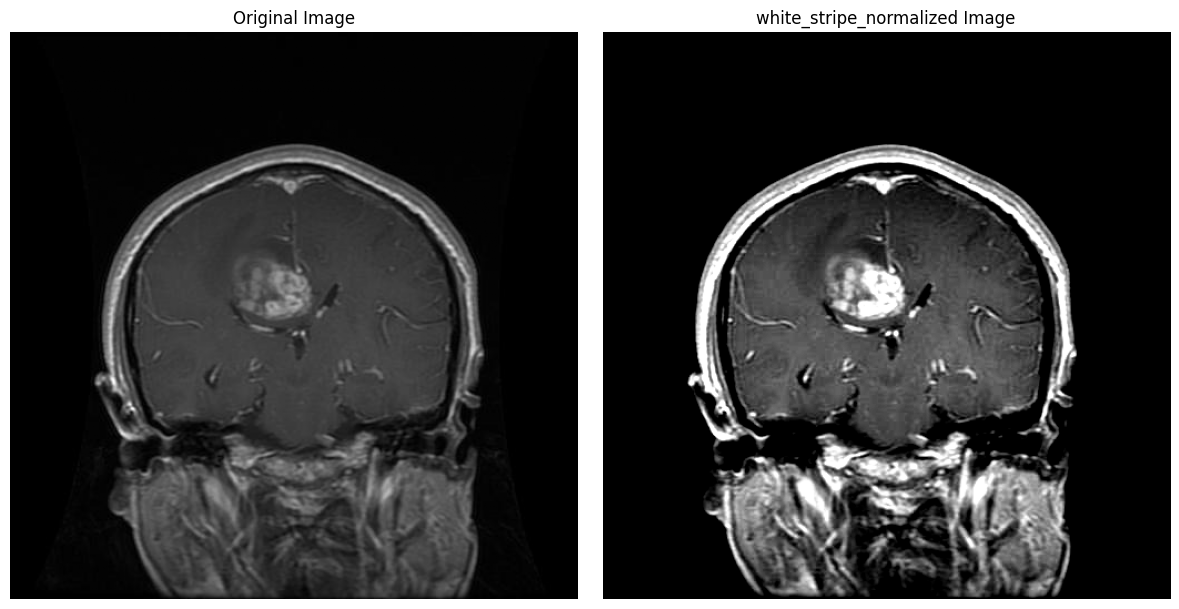

In [6]:
image_path = 'Brain tumor_D2_Original\glioma\Te-gl_0040.jpg' 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

corrected_image = white_stripe_normalization(image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='gray')
plt.title('white_stripe_normalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Process datasets
process_dataset(input_dir="Brain tumor_D2_Original",
                output_dir="Brain tumor_D2_White Strip Normalization")

Processing pituitary: 100%|██████████| 300/300 [00:09<00:00, 31.57it/s]
